In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import pickle
import numpy as np
from text_processing_utils import *
import glob
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
cleaned_ratings = np.array(pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_ratings.pickle", "rb")))
cleaned_reviews = pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_reviews.pickle", "rb"))
vocabulary_dict = pickle.load(open("/content/drive/MyDrive/data/scaledata/vocabulary_dict.pickle", "rb"))

In [ ]:
# randomly split the movie reviews data into training/testing parts (80:20)
np.random.seed(7654321)
train_indices = np.random.choice(np.arange(len(cleaned_ratings)), int(len(cleaned_ratings)*0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(cleaned_ratings)), train_indices)
print(len(train_indices), len(test_indices))
train_bow = convert_bow([cleaned_reviews[i] for i in train_indices])
test_bow = convert_bow([cleaned_reviews[i] for i in test_indices])
train_y = cleaned_ratings[train_indices]
test_y = cleaned_ratings[test_indices]

4004 1002


In [ ]:
K = 24 # number of topics
V = len(vocabulary_dict) # vocabulary size

In [ ]:
## Loading the optimized global parameters from the model training phase
np.random.seed(12345)
di = 2
new_alpha = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/alpha.pickle".format(di), "rb"))
new_xi = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/xi.pickle".format(di), "rb"))
new_eta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/eta.pickle".format(di), "rb"))
new_delta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/delta.pickle".format(di), "rb"))
new_Lambda = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/Lambda.pickle".format(di), "rb"))

input_data_x = test_bow
input_data_y = test_y
fpath = "fragmented_output_files_new/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    for fn in glob.glob(fpath + "*"):
        os.remove(fn)
epsilon = 1e-4 # stopping criteria for convergence in E step
predict = True # prediction mode for evaluating the test set

## Run one iteration of unsupervised E step (parallelized) to identify the optimal local variational parameters for all documents in the test set.
## The optimized phi identified from the unsupervised batch VI will be used to generate the predictions for response variable y in the test set
%run -i "parallelized_sLDA_E_step.py" # unsupervised batch VI for sLDA is way faster than supervised one
all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
new_gamma_dict = merge_dict(all_gamma)
new_gamma = create_gamma_matrix(new_gamma_dict)
all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
new_phi = merge_dict(all_phi)

In [ ]:
# Topic words of each topic learned from training sLDA, with corresponding coefficients (eta)
inverse_vocabulary_dict = {v:k for k,v in vocabulary_dict.items()}
for t in range(K):
    word_indices = np.argsort(new_Lambda[t,:])[::-1][:10]
    print("Topic {}:".format(t+1), [inverse_vocabulary_dict[j] for j in word_indices], "eta =", new_eta[t])

Topic 1: ['visual', 'thing', 'van', 'place', 'deep', 'screen', 'manner', 'heart', 'opportunity', 'every'] eta = 0.5638959413893068
Topic 2: ['movies', 'effects', 'why', '0', 'enjoyable', 'average', 'bond', 'where', 'world', 'ever'] eta = 0.5920370319695697
Topic 3: ['line', 'williams', 'subscribe', 'go', 'robin', 'playing', 'r', 'adventures', 'problems', 'subject'] eta = 0.554506452783323
Topic 4: ['nothing', 'parker', 'day', 'proves', 'rocky', 'interesting', 'arnold', 'queen', 'simply', 'wife'] eta = 0.6028782874051203
Topic 5: ['narrative', 'novel', 'less', 'go', 'place', 'modern', 'half', 'david', 'style', 'alone'] eta = 0.5970234524659805
Topic 6: ['action', 'star', 'big', 'lines', 'takes', 'finally', 'screen', 'watching', 'full', 'guy'] eta = 0.5637969402664377
Topic 7: ['motion', 'seems', 'moments', 'however', 'screenplay', 'once', 'far', 'feeling', 'rating', 'showing'] eta = 0.6159751760749123
Topic 8: ['use', 'age', 'version', 'relationship', 'sort', 'until', 'black', 'effectiv

In [ ]:
# Generate predictions for the response variable y for the test set:
# For Gaussian response, y_hat = E[phi_bar^T eta]
phi_bar = {k:v.mean(axis=0) for k,v in new_phi.items()}
pred_y = np.empty((len(test_y),))
for indx in range(len(test_y)):
    pred_y[indx] = np.dot(phi_bar[indx], new_eta)

In [ ]:
# performance metrics:
def predictive_R2(test_y, pred_y):
    return 1 - np.mean((test_y - pred_y)**2) / np.var(test_y)

print("Predictive R^2 =", predictive_R2(test_y, pred_y))
print("Pearson correlation coefficient =", pearsonr(test_y, pred_y).statistic)

Predictive R^2 = 0.002481341300622053
Pearson correlation coefficient = 0.11308538785243799


In [ ]:
new_eta

array([0.56389594, 0.59203703, 0.55450645, 0.60287829, 0.59702345,
       0.56379694, 0.61597518, 0.59928166, 0.58541121, 0.59709725,
       0.59151871, 0.56165136, 0.55273317, 0.59914976, 0.59115167,
       0.56871214, 0.58176553, 0.56911649, 0.58404494, 0.5828546 ,
       0.58177028, 0.58946638, 0.55215552, 0.60303609])

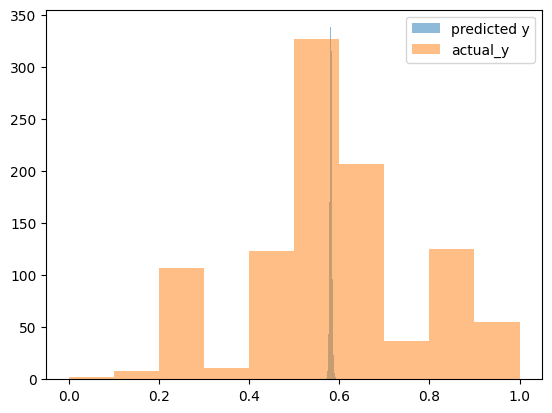

In [ ]:
# Compare the predicted histogram of predicted vs. actual y values
plt.hist(pred_y, alpha=0.5, label='x')
plt.hist(test_y, alpha=0.5, label='y')
plt.legend(['predicted y', 'actual_y'], loc='upper right')
plt.show()